In [43]:
import requests
import time
import json
import pandas as pd
import os
from PIL import Image, ImageDraw
from IPython.display import display

# Examples
- <a href="#health" style="font-size:20px;">/health</a>
- <a href="#ocr" style="font-size:20px;">/ocr</a>
- <a href="#start_ocr" style="font-size:20px;">/start_ocr</a>
- <a href="#results" style="font-size:20px;">/results</a>
- <a href="#create_searchable" style="font-size:20px;">/create_searchable</a>


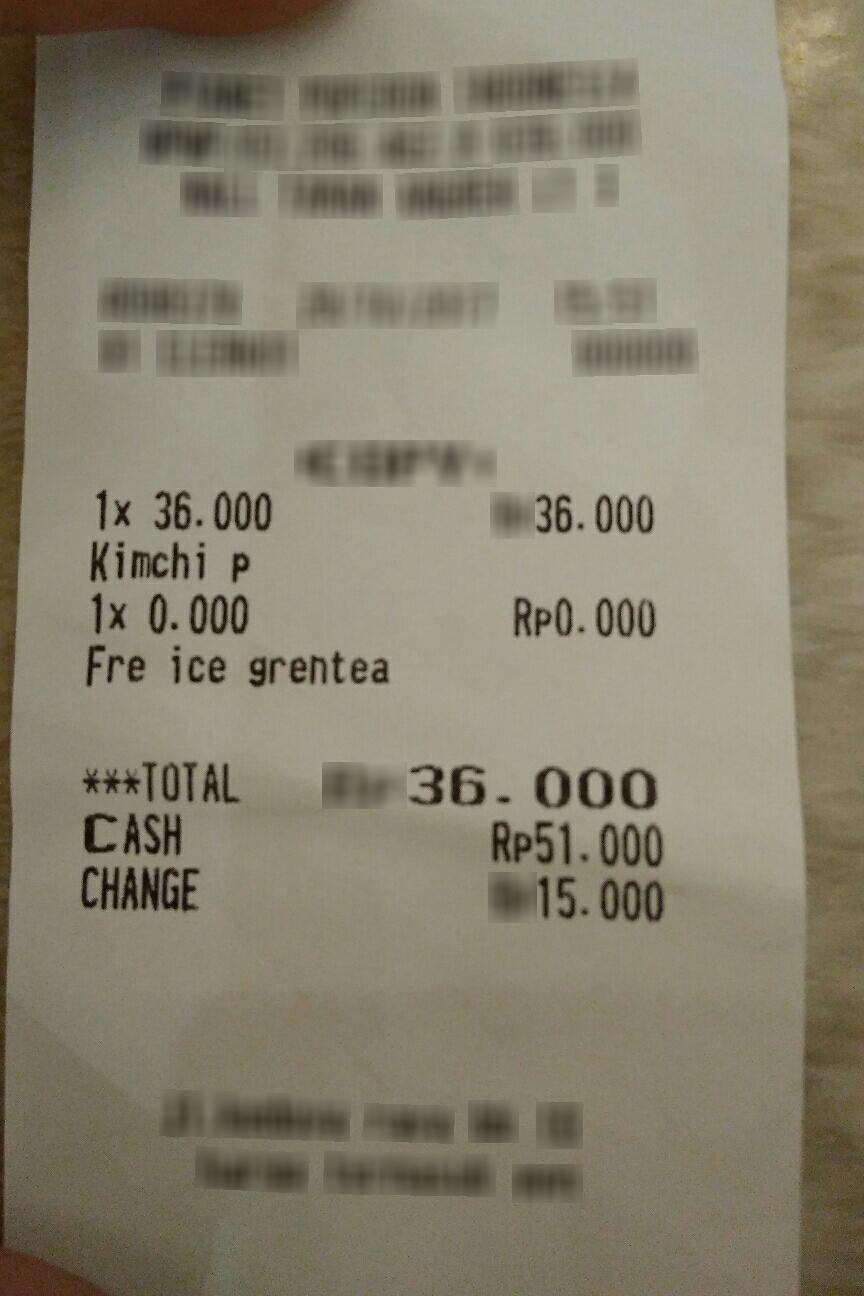

In [44]:
container_url = "http://localhost:8000" # URL of the container
file_path = "../tests/receipt.jpg" # Path to the image file

image = Image.open(file_path)
display(image)

# /health
<a id="health"></a>

In [45]:
# Send a GET request to the health endpoint
response = requests.get(f"{container_url}/health")

# Check if the quest was successful
if response.status_code == 200:
    health_status = response.json()
    print(f"Health Check: {health_status}")
else:
    print(f"Failed to get health status. Status code: {response.status_code}, Response: {response.text}")


Health Check: {'status': 'healthy'}


# /ocr
<a id="ocr"></a>

In [46]:
# Read the file and send a POST request to the /ocr endpoint [SYNC]
with open(file_path, "rb") as file:
    files = {'file': file}
    response = requests.post(f"{container_url}/ocr/", files=files)
    print(f"Request URL: {container_url}/ocr/")

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    task_id = data["task_id"]
    print(f"File processed successfully. \nTask ID: {task_id}\n")
    print(json.dumps(response.json(), indent=4))
else:
    print("Failed to upload image.")
    print("Status code:", response.status_code)
    print("Response:", response.text)

Request URL: http://localhost:8000/ocr/
File processed successfully. 
Task ID: 0a21587e-3530-44a3-ad2c-d136f061944e

{
    "task_id": "0a21587e-3530-44a3-ad2c-d136f061944e",
    "file_name": "receipt.jpg",
    "file_type": "Image",
    "num_pages": 1,
    "start_datetime": "2024-06-06T15:23:23.530718",
    "end_datetime": "2024-06-06T15:23:24.140737",
    "status": "completed",
    "dpi": null,
    "page_info": [
        {
            "page_num": 1,
            "width": 864,
            "height": 1296
        }
    ],
    "psm_type": 3,
    "results": [
        {
            "level": 1,
            "page_num": 1,
            "block_num": 0,
            "par_num": 0,
            "line_num": 0,
            "word_num": 0,
            "left": 0,
            "top": 0,
            "width": 864,
            "height": 1296,
            "conf": -1,
            "text": ""
        },
        {
            "level": 2,
            "page_num": 1,
            "block_num": 1,
            "par_num": 0,

In [47]:
# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for result in response.json()["results"]:
    text = result["text"].strip()
    if text:  # Filter out boxes with no content
        left = result["left"]
        top = result["top"]
        width = result["width"]
        height = result["height"]
        right = left + width
        bottom = top + height
        draw.rectangle([left, top, right, bottom], outline="red", width=2)

# Display the image with bounding boxes
image.show()

# /start_ocr
<a id="start_ocr"></a>

In [48]:
# Read the file and send a POST request to the /start_ocr endpoint [ASYNC]
with open(file_path, "rb") as file:
    files = {'file': file}
    response = requests.post(f"{container_url}/start_ocr/", files=files)
    print(f"Request URL: {container_url}/start_ocr/")

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    task_id = data["task_id"]
    print(f"Processing started successfully. \nTask ID: {task_id}")
else:
    print("Failed to process file.")
    print("Status code:", response.status_code)
    print("Response:", response.text)

Request URL: http://localhost:8000/start_ocr/
Processing started successfully. 
Task ID: ea8c7754-303e-493d-82a6-19e923f9369b


# /results
<a id="results"></a>

In [49]:
# Get the OCR results from the /results endpoint
while True:
    result_response = requests.get(f"{container_url}/results/{task_id}")
    if result_response.status_code == 200:
        result_data = result_response.json()
        if result_data["state"] == "SUCCESS":
            print("Successfully retrieved the result.")
            break
        elif result_data["state"] == "PENDING":
            print("Processing is still in progress. Retrying in 5 seconds...")
            time.sleep(5)
        else:
            print("Unexpected state:", result_data["state"])
            break
    else:
        print(f"Failed to retrieve result. Status code: {result_response.status_code}")
        break

# Display the results in a DataFrame
ocr_results = result_data.get("results", [])
df = pd.DataFrame(ocr_results)
df.head(20)

Successfully retrieved the result.


,level,page_num,block_num,par_num,line_num,word_num,left,top,conf,text
0,1,1,0,0,0,0,0,0,864,1296
1,2,1,1,0,0,0,0,405,864,428
2,3,1,1,1,0,0,0,405,864,428
3,4,1,1,1,1,0,0,405,366,169
4,5,1,1,1,1,1,0,405,366,169
5,4,1,1,1,2,0,0,574,864,136
6,5,1,1,1,2,1,0,574,86,136
7,5,1,1,1,2,2,389,574,475,136
8,4,1,1,1,3,0,0,710,864,123
9,5,1,1,1,3,1,0,710,864,123


# /create_searchable
<a id="create_searchable"></a>

In [50]:
# Read the file and send a POST request to the /create_searchable endpoint
with open(file_path, "rb") as file:
    files = {'file': file}
    response = requests.post(f"{container_url}/create_searchable/", files=files)
    print(f"Request URL: {container_url}/create_searchable/")

# Check if the request was successful
if response.status_code == 200:
    print(f"Searchable PDF created successfully. \nTask ID: {task_id}\n")

    # Save the searchable PDF to a file
    base_name = os.path.splitext(file_path)[0]
    result_file_path = f"{base_name}_ocr.pdf"
    with open(result_file_path, "wb") as result_file:
        result_file.write(response.content)
    print(f"Searchable PDF saved as: {result_file_path}")
else:
    print("Failed to create searchable PDF.")
    print("Status code:", response.status_code)
    print("Response:", response.text)

Request URL: http://localhost:8000/create_searchable/
Searchable PDF created successfully. 
Task ID: ea8c7754-303e-493d-82a6-19e923f9369b

Searchable PDF saved as: ../tests/receipt_ocr.pdf
